In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import gc
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter1d
import mne
from mne_connectivity import spectral_connectivity_epochs
#truncate mne print
mne.set_log_level('WARNING')

In [ ]:
def smooth_with_gaussian(data, sigma=3):
    return gaussian_filter1d(data, sigma=sigma, axis=1) 

def preprocess(data):
    stds = np.std(data[:, :], axis=0)
    non_constant_cols = stds.astype(float) > 1e-6    #finds the time points where std is not 0
    const_cols = stds.astype(float) <= 1e-6    #finds the time points where std is 0

    z = np.zeros_like(data[:, :])   #creates an array of zeros with the same shape as the data
    z[:, non_constant_cols] = zscore(data[:, non_constant_cols], axis=0)  #in the columns where std is not 0, zscores the data
    z[:, const_cols] = np.mean(data[:, const_cols], axis=0)

 
    if np.isnan(z).any():
        raise ValueError("Data contains NaN values after normalization.")

    return z


file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]
def load_data():
    l_al = []
    r_al = []
    l_ar = []
    r_ar = []
    a_al =[]
    a_ar = []
    for file_number in  file_numbers:
        file_total = time.time()
        file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
        load_data_start_time = time.time()
        data = pickle.load(open(file_path, 'rb'))
        elapsed_time = time.time() - load_data_start_time
        print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")

        label_left = data['label_left'][0]
        label_right = data['label_right'][0]
        attend_01 = data['attend'][0]
        omitted = data['omit'][0]
        relevant = np.where(omitted ==0)[0]
    
        left_input_SP = data['SP'][0][0][relevant,  100:350]
        right_input_SP = data['SP'][0][1][relevant,  100:350]
        attention_SP = data['SP'][0][2][relevant,  100:350]

        sigma = 2

        left_sm = smooth_with_gaussian(left_input_SP, sigma=sigma) 
        right_sm = smooth_with_gaussian(right_input_SP, sigma=sigma) 
        att_sm = smooth_with_gaussian(attention_SP, sigma=sigma) 

        num_trials, num_samples, num_neurons = left_input_SP.shape
        num_neurons_attention = 80

                
        for j in range(0, num_trials):
            for i in range(0, num_neurons):
                count_left = np.count_nonzero(left_input_SP[j, :, i] == 1)
                if count_left > 0:
                    left_sm[j, :, i] /= count_left
                count_right = np.count_nonzero(right_input_SP[j, :, i] == 1)
                if count_right > 0:
                    right_sm[j, :, i] /= count_right


            for i in range(0, num_neurons_attention):
                count_attention = np.count_nonzero(attention_SP[j, :, i] == 1)
                if count_attention > 0:
                    att_sm[j, :, i] /= count_attention


        left_input_SP = np.sum(left_sm, axis=2)
        right_input_SP = np.sum(right_sm, axis=2)
        attention_SP = np.sum(att_sm, axis=2)

        #preprocess here now that we have traces of all of the relavant trials
        left_indices_agg = np.where((omitted ==0) & (attend_01 == 0) & (label_left != label_right))[0]  #indices of agg where left
        _, left_indices, _ = np.intersect1d(relevant, left_indices_agg, return_indices = True)   #indices for relevant processed data where attention left
        right_indices_agg = np.where((omitted ==0) & (attend_01 == 1) & (label_left != label_right))[0]
        _, right_indices, _ = np.intersect1d(relevant, right_indices_agg, return_indices = True)

        left_input_SP = preprocess(left_input_SP)
        right_input_SP = preprocess(right_input_SP)
        attention_SP = preprocess(attention_SP)

        #splitting left and right
        l_al.append(left_input_SP[left_indices, :])
        r_al.append(right_input_SP[left_indices, :])
        a_al.append(attention_SP[left_indices, :])

        l_ar.append(left_input_SP[right_indices, :])
        r_ar.append(right_input_SP[right_indices, :])
        a_ar.append(attention_SP[right_indices, :])

        

        del left_input_SP, right_input_SP, attention_SP
        gc.collect()
        del(data)
        gc.collect()
        print(f'Dataset {file_number} complete in', time.time() - file_total)

    return l_al, r_al, l_ar, r_ar, a_al, a_ar



In [55]:
l_al, r_al, l_ar, r_ar, a_al, a_ar = load_data()

Dataset 1 loaded in 22.78 seconds
Dataset 1 complete in 32.26982927322388
Dataset 1 complete in 32.26982927322388
Dataset 2 loaded in 8.75 seconds
Dataset 2 loaded in 8.75 seconds
Dataset 2 complete in 18.569000482559204
Dataset 2 complete in 18.569000482559204
Dataset 4 loaded in 8.93 seconds
Dataset 4 loaded in 8.93 seconds
Dataset 4 complete in 16.081558227539062
Dataset 4 complete in 16.081558227539062
Dataset 8 loaded in 8.64 seconds
Dataset 8 loaded in 8.64 seconds
Dataset 8 complete in 16.768514156341553
Dataset 8 complete in 16.768514156341553
Dataset 14 loaded in 9.04 seconds
Dataset 14 loaded in 9.04 seconds
Dataset 14 complete in 18.36772108078003
Dataset 14 complete in 18.36772108078003
Dataset 15 loaded in 13.06 seconds
Dataset 15 loaded in 13.06 seconds
Dataset 15 complete in 22.73269271850586
Dataset 15 complete in 22.73269271850586
Dataset 20 loaded in 11.16 seconds
Dataset 20 loaded in 11.16 seconds
Dataset 20 complete in 24.70556664466858
Dataset 20 complete in 24.705

In [56]:
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
sfreq = 500.0
ch_names = ['left_input', 'right_input', 'attention_layer']
ch_types = ['eeg', 'eeg', 'eeg']

freq_ranges = [(0, 4), (4, 8), (8, 13), (13, 30), (30, 80)]

# Initialize granger_results as a nested dictionary for each file, condition, and band


def granger_calc(left, right, attention):
    results = []
    freqs = []
    for idx, fn in enumerate(file_numbers):
        info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

        data= np.stack([
            left[idx], 
            right[idx], 
            attention[idx]
        ], axis=1) 
        print(data.shape)

        epochs = mne.EpochsArray(
            data,
            info, 
            tmin=0, 
            baseline=None
        )

            # Define channel indices for Granger causality
        seeds = np.array([[0], [1]])
        targets = np.array([[2], [2]])
        indices = (seeds, targets)

        # Compute Granger causality
        gc = spectral_connectivity_epochs(
            epochs, method='gc', indices=indices, sfreq=sfreq,
            fmin=0.5, fmax=40.0, tmin=0.0, tmax=(250 - 1) / sfreq, gc_n_lags=5
        )

      
        # Extract Granger causality data
        gc_data = gc.get_data()
        freqs = gc.freqs

        results.append(gc_data)
        freqs = gc.freqs

    return results, freqs


In [57]:
left_results, freqs = granger_calc(l_al, r_al, a_al)
right_results, freqs = granger_calc(l_ar, r_ar, a_ar)

(468, 3, 250)


C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray | 468 events (all good), 0 – 0.498 s (baseline off), ~2.7 MiB, data loaded,
 '1': 468>, so metadata was not modified.
  gc = spectral_connectivity_epochs(
C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: fmin=0.500 Hz corresponds to 0.250 < 5 cycles based on the epoch length 0.500 sec, need at least 10.000 sec epochs or fmin=10.000. Spectrum estimate will be unreliable.
  gc = spectral_connectivity_epochs(


(463, 3, 250)


C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray | 463 events (all good), 0 – 0.498 s (baseline off), ~2.7 MiB, data loaded,
 '1': 463>, so metadata was not modified.
  gc = spectral_connectivity_epochs(
C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: fmin=0.500 Hz corresponds to 0.250 < 5 cycles based on the epoch length 0.500 sec, need at least 10.000 sec epochs or fmin=10.000. Spectrum estimate will be unreliable.
  gc = spectral_connectivity_epochs(


(471, 3, 250)


C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray | 471 events (all good), 0 – 0.498 s (baseline off), ~2.7 MiB, data loaded,
 '1': 471>, so metadata was not modified.
  gc = spectral_connectivity_epochs(
C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: fmin=0.500 Hz corresponds to 0.250 < 5 cycles based on the epoch length 0.500 sec, need at least 10.000 sec epochs or fmin=10.000. Spectrum estimate will be unreliable.
  gc = spectral_connectivity_epochs(


(492, 3, 250)


C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray | 492 events (all good), 0 – 0.498 s (baseline off), ~2.8 MiB, data loaded,
 '1': 492>, so metadata was not modified.
  gc = spectral_connectivity_epochs(
C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: fmin=0.500 Hz corresponds to 0.250 < 5 cycles based on the epoch length 0.500 sec, need at least 10.000 sec epochs or fmin=10.000. Spectrum estimate will be unreliable.
  gc = spectral_connectivity_epochs(


(503, 3, 250)


C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray | 503 events (all good), 0 – 0.498 s (baseline off), ~2.9 MiB, data loaded,
 '1': 503>, so metadata was not modified.
  gc = spectral_connectivity_epochs(
C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: fmin=0.500 Hz corresponds to 0.250 < 5 cycles based on the epoch length 0.500 sec, need at least 10.000 sec epochs or fmin=10.000. Spectrum estimate will be unreliable.
  gc = spectral_connectivity_epochs(


(448, 3, 250)


C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray | 448 events (all good), 0 – 0.498 s (baseline off), ~2.6 MiB, data loaded,
 '1': 448>, so metadata was not modified.
  gc = spectral_connectivity_epochs(
C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: fmin=0.500 Hz corresponds to 0.250 < 5 cycles based on the epoch length 0.500 sec, need at least 10.000 sec epochs or fmin=10.000. Spectrum estimate will be unreliable.
  gc = spectral_connectivity_epochs(


(452, 3, 250)


C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray | 452 events (all good), 0 – 0.498 s (baseline off), ~2.6 MiB, data loaded,
 '1': 452>, so metadata was not modified.
  gc = spectral_connectivity_epochs(
C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: fmin=0.500 Hz corresponds to 0.250 < 5 cycles based on the epoch length 0.500 sec, need at least 10.000 sec epochs or fmin=10.000. Spectrum estimate will be unreliable.
  gc = spectral_connectivity_epochs(


(488, 3, 250)


C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray | 488 events (all good), 0 – 0.498 s (baseline off), ~2.8 MiB, data loaded,
 '1': 488>, so metadata was not modified.
  gc = spectral_connectivity_epochs(
C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: fmin=0.500 Hz corresponds to 0.250 < 5 cycles based on the epoch length 0.500 sec, need at least 10.000 sec epochs or fmin=10.000. Spectrum estimate will be unreliable.
  gc = spectral_connectivity_epochs(


(536, 3, 250)


C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray | 536 events (all good), 0 – 0.498 s (baseline off), ~3.1 MiB, data loaded,
 '1': 536>, so metadata was not modified.
  gc = spectral_connectivity_epochs(
C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: fmin=0.500 Hz corresponds to 0.250 < 5 cycles based on the epoch length 0.500 sec, need at least 10.000 sec epochs or fmin=10.000. Spectrum estimate will be unreliable.
  gc = spectral_connectivity_epochs(


(479, 3, 250)


C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray | 479 events (all good), 0 – 0.498 s (baseline off), ~2.7 MiB, data loaded,
 '1': 479>, so metadata was not modified.
  gc = spectral_connectivity_epochs(
C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: fmin=0.500 Hz corresponds to 0.250 < 5 cycles based on the epoch length 0.500 sec, need at least 10.000 sec epochs or fmin=10.000. Spectrum estimate will be unreliable.
  gc = spectral_connectivity_epochs(


(455, 3, 250)


C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray | 455 events (all good), 0 – 0.498 s (baseline off), ~2.6 MiB, data loaded,
 '1': 455>, so metadata was not modified.
  gc = spectral_connectivity_epochs(
C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: fmin=0.500 Hz corresponds to 0.250 < 5 cycles based on the epoch length 0.500 sec, need at least 10.000 sec epochs or fmin=10.000. Spectrum estimate will be unreliable.
  gc = spectral_connectivity_epochs(


(473, 3, 250)


C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray | 473 events (all good), 0 – 0.498 s (baseline off), ~2.7 MiB, data loaded,
 '1': 473>, so metadata was not modified.
  gc = spectral_connectivity_epochs(
C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: fmin=0.500 Hz corresponds to 0.250 < 5 cycles based on the epoch length 0.500 sec, need at least 10.000 sec epochs or fmin=10.000. Spectrum estimate will be unreliable.
  gc = spectral_connectivity_epochs(


(471, 3, 250)


C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray | 471 events (all good), 0 – 0.498 s (baseline off), ~2.7 MiB, data loaded,
 '1': 471>, so metadata was not modified.
  gc = spectral_connectivity_epochs(
C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: fmin=0.500 Hz corresponds to 0.250 < 5 cycles based on the epoch length 0.500 sec, need at least 10.000 sec epochs or fmin=10.000. Spectrum estimate will be unreliable.
  gc = spectral_connectivity_epochs(


(525, 3, 250)


C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray | 525 events (all good), 0 – 0.498 s (baseline off), ~3.0 MiB, data loaded,
 '1': 525>, so metadata was not modified.
  gc = spectral_connectivity_epochs(
C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: fmin=0.500 Hz corresponds to 0.250 < 5 cycles based on the epoch length 0.500 sec, need at least 10.000 sec epochs or fmin=10.000. Spectrum estimate will be unreliable.
  gc = spectral_connectivity_epochs(


(505, 3, 250)


C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray | 505 events (all good), 0 – 0.498 s (baseline off), ~2.9 MiB, data loaded,
 '1': 505>, so metadata was not modified.
  gc = spectral_connectivity_epochs(
C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: fmin=0.500 Hz corresponds to 0.250 < 5 cycles based on the epoch length 0.500 sec, need at least 10.000 sec epochs or fmin=10.000. Spectrum estimate will be unreliable.
  gc = spectral_connectivity_epochs(


(496, 3, 250)


C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray | 496 events (all good), 0 – 0.498 s (baseline off), ~2.8 MiB, data loaded,
 '1': 496>, so metadata was not modified.
  gc = spectral_connectivity_epochs(
C:\Users\joshu\AppData\Local\Temp\ipykernel_21152\907049264.py:37: RuntimeWarning: fmin=0.500 Hz corresponds to 0.250 < 5 cycles based on the epoch length 0.500 sec, need at least 10.000 sec epochs or fmin=10.000. Spectrum estimate will be unreliable.
  gc = spectral_connectivity_epochs(


In [ ]:
#    gc_data_left[0, :], GC Left -> Attention for attention left
#    gc_data_left[1, :], GC Right -> Attention for attention left

#granger_data_left has lal and rar data, in [trials, freq] format. want mean acorss trials for each band

print(left_results[1].shape)


(2, 20)


In [62]:
# Plot Granger causality vs frequency for each connection in each dataset
import matplotlib.pyplot as plt

def plot_granger(data):
    for ds_idx, gc_arr in enumerate(data):
        plt.figure(figsize=(10, 5))
        plt.plot(freqs, gc_arr[0, :], label='Left → Attention')
        plt.plot(freqs, gc_arr[1, :], label='Right → Attention')
        plt.title(f'Granger Causality vs Frequency (Dataset {file_numbers[ds_idx]})')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Granger Causality')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

#plot_granger(left_results)
#plot_granger(right_results)

# If you want to do the same for right_results, repeat with right_results instead of left_results.

In [68]:
# Compute average Granger causality for each band, for each dataset, for each condition
# Output arrays: shape (n_datasets, n_bands)

def compute_band_averages(results, freqs, bands, freq_ranges):
    n_datasets = len(results)
    n_bands = len(bands)
    freqs_arr = np.array(freqs)  # Ensure freqs is a NumPy array
    left_to_att = np.zeros((n_datasets, n_bands))
    right_to_att = np.zeros((n_datasets, n_bands))
    for idx, gc in enumerate(results):
        for band_idx, (fmin, fmax) in enumerate(freq_ranges):
            band_mask = (freqs_arr >= fmin) & (freqs_arr < fmax)
            left_to_att[idx, band_idx] = np.mean(gc[0, band_mask])
            right_to_att[idx, band_idx] = np.mean(gc[1, band_mask])
    return left_to_att, right_to_att

# For attend-left (l_al, r_al)
lal_band_avg, ral_band_avg = compute_band_averages(left_results, freqs, bands, freq_ranges)
# For attend-right (l_ar, r_ar)
lar_band_avg, rar_band_avg = compute_band_averages(right_results, freqs, bands, freq_ranges)

g_in = (lal_band_avg + rar_band_avg) / 2
g_out = (lar_band_avg + ral_band_avg) / 2
              

In [78]:
def plot_Granger_bands(g_in, g_out, bands=None, width=0.35):
    if bands is None:
        n_bands = g_in.shape[1]
        bands = [f'Band {i+1}' for i in range(n_bands)]
    else:
        n_bands = len(bands)

    x = np.arange(n_bands)

    fig, ax = plt.subplots(figsize=(10, 7))

    # Boxplots: In at x-width/2, Out at x+width/2
    bp_in = ax.boxplot([g_in[:, i] for i in range(n_bands)],
                       positions=x - width/2,
                       widths=width,
                       patch_artist=True,
                       boxprops=dict(facecolor='C0', alpha=0.6),
                       medianprops=dict(color='k'))
    bp_out = ax.boxplot([g_out[:, i] for i in range(n_bands)],
                        positions=x + width/2,
                        widths=width,
                        patch_artist=True,
                        boxprops=dict(facecolor='C1', alpha=0.6),
                        medianprops=dict(color='k'))

    ax.set_xticks(x)
    ax.set_xticklabels(bands)
    ax.set_xlabel('Frequency Band')
    ax.set_ylabel('Granger Causality')
    ax.set_title('Granger Causality by Band (In vs Out)')

    # Legend
    handles = [bp_in['boxes'][0], bp_out['boxes'][0]]
    ax.legend(handles, ['In', 'Out'], loc='upper right', fontsize=16)

    plt.tight_layout()
    plt.show()


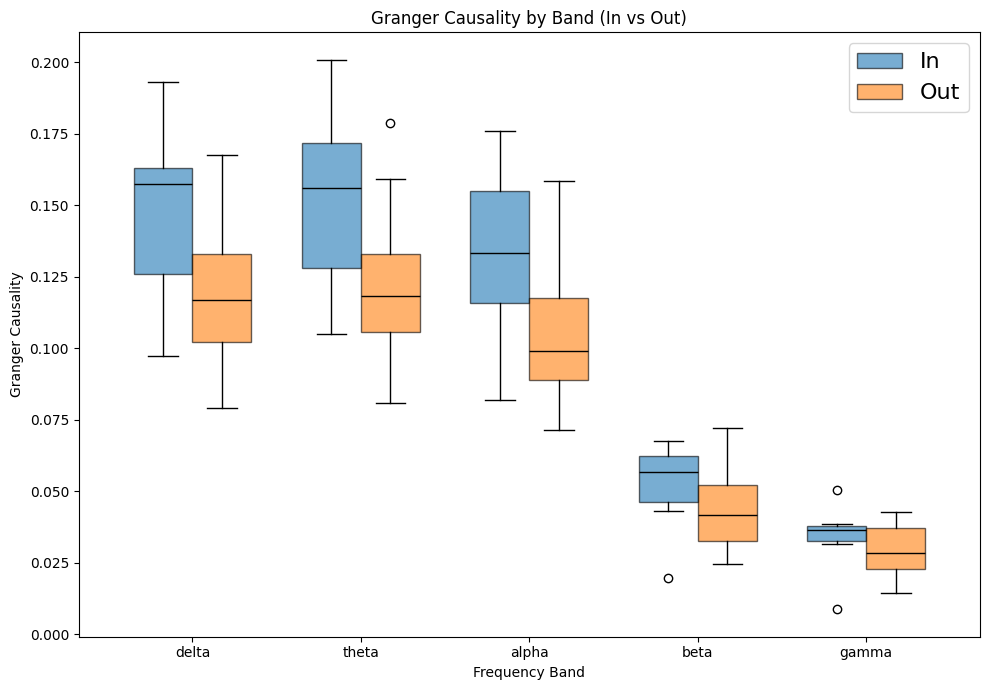

In [79]:
plot_Granger_bands(g_in, g_out, bands = bands)

In [82]:
#ttest on each band
from scipy.stats import ttest_rel
def paired_ttest(g_in, g_out):
    t_stats = []
    p_values = []
    for i in range(g_in.shape[1]):
        t_stat, p_val = ttest_rel(g_in[:, i], g_out[:, i])
        t_stats.append(t_stat)
        p_values.append(p_val)
    return np.array(t_stats), np.array(p_values)

t_stats, p_values = paired_ttest(g_in, g_out)

# Print t-statistics and p-values
for i, band in enumerate(bands):
    print(f"{band}: t-statistic = {t_stats[i]:.3f}, p-value = {p_values[i]}")

delta: t-statistic = 2.339, p-value = 0.05195218563327634
theta: t-statistic = 2.583, p-value = 0.0363080566871089
alpha: t-statistic = 2.452, p-value = 0.04395914925538955
beta: t-statistic = 1.558, p-value = 0.16318815976467152
gamma: t-statistic = 1.216, p-value = 0.2633224235263616
